## Packages and setup

In [13]:
import os
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [14]:
np.random.seed(26) #for rereproducibility, we set random seed .

In [15]:
!ls ../input/planets-dataset/planet/planet

sample_submission.csv  test-jpg  train-jpg  train_classes.csv


# Data Exploration

### Labels distribution

Let's first load the training dataset and quantify the label distributions.

In [16]:
train_path = "../input/planets-dataset/planet/planet/train-jpg"
test_path = "../input/planets-dataset/planet/planet/test-jpg"
class_path = "../input/planets-dataset/planet/planet/train_classes.csv"
df_class = pd.read_csv(class_path)

In [17]:
print(
    f"train files: {len(os.listdir(train_path))}, "
    f"test files: {len(os.listdir(test_path))}"
)

train files: 40479, test files: 40669


In [18]:
df_class.shape

(40479, 2)

In [19]:
df_class.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


***Simple counter of individual label, by splitting them from tags.***

Creating a now column named "list_tags" having tags converted into a list, row wise

In [20]:
df_class["list_tags"] = df_class.tags.str.split(" ")
df_class.head(10)

,image_name,tags,list_tags
0,train_0,haze primary,"[haze, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"
5,train_5,haze primary water,"[haze, primary, water]"
6,train_6,agriculture clear cultivation primary water,"[agriculture, clear, cultivation, primary, water]"
7,train_7,haze primary,"[haze, primary]"
8,train_8,agriculture clear cultivation primary,"[agriculture, clear, cultivation, primary]"
9,train_9,agriculture clear cultivation primary road,"[agriculture, clear, cultivation, primary, road]"


Creating a list of all the tags present in the lists in the list_tags column and then counting each tags frequency

In [21]:
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)

counter_tags

Counter({'haze': 2697,
         'primary': 37513,
         'agriculture': 12315,
         'clear': 28431,
         'water': 7411,
         'habitation': 3660,
         'road': 8071,
         'cultivation': 4547,
         'slash_burn': 209,
         'cloudy': 2089,
         'partly_cloudy': 7261,
         'conventional_mine': 100,
         'bare_ground': 862,
         'artisinal_mine': 339,
         'blooming': 332,
         'selective_logging': 340,
         'blow_down': 101})

In [22]:
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")
fig = px.bar(df_tags, x="total", y="tag", orientation="h", 
             color="total",
)
fig.update_layout(title="Class distribution")
fig.update_layout(width=1080, height=720, bargap=0.05)
fig.show()

As shown in the barplot above that there is a major class imbalance with some rarer tags being barely present in the dataset and, thus, will create problem in training the model. Therefore, we identify these problematic tags in a seperate list.

In [23]:
Rarer_tags = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

# Class visualisation


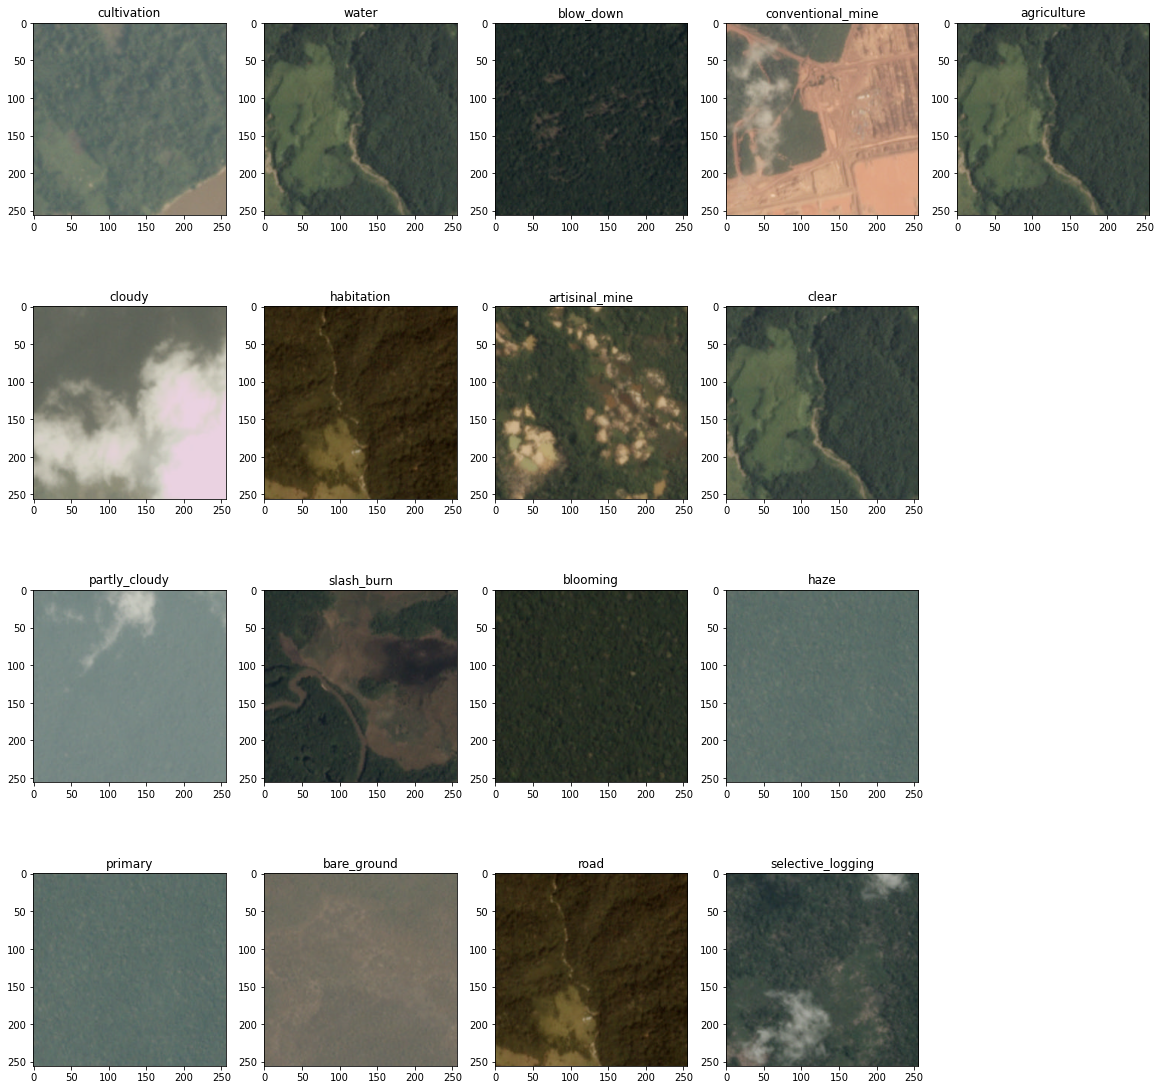

In [24]:
all_tags = list(set(tags))
Number_tags = len(all_tags)
fig, axes = plt.subplots(4, (Number_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(train_path, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

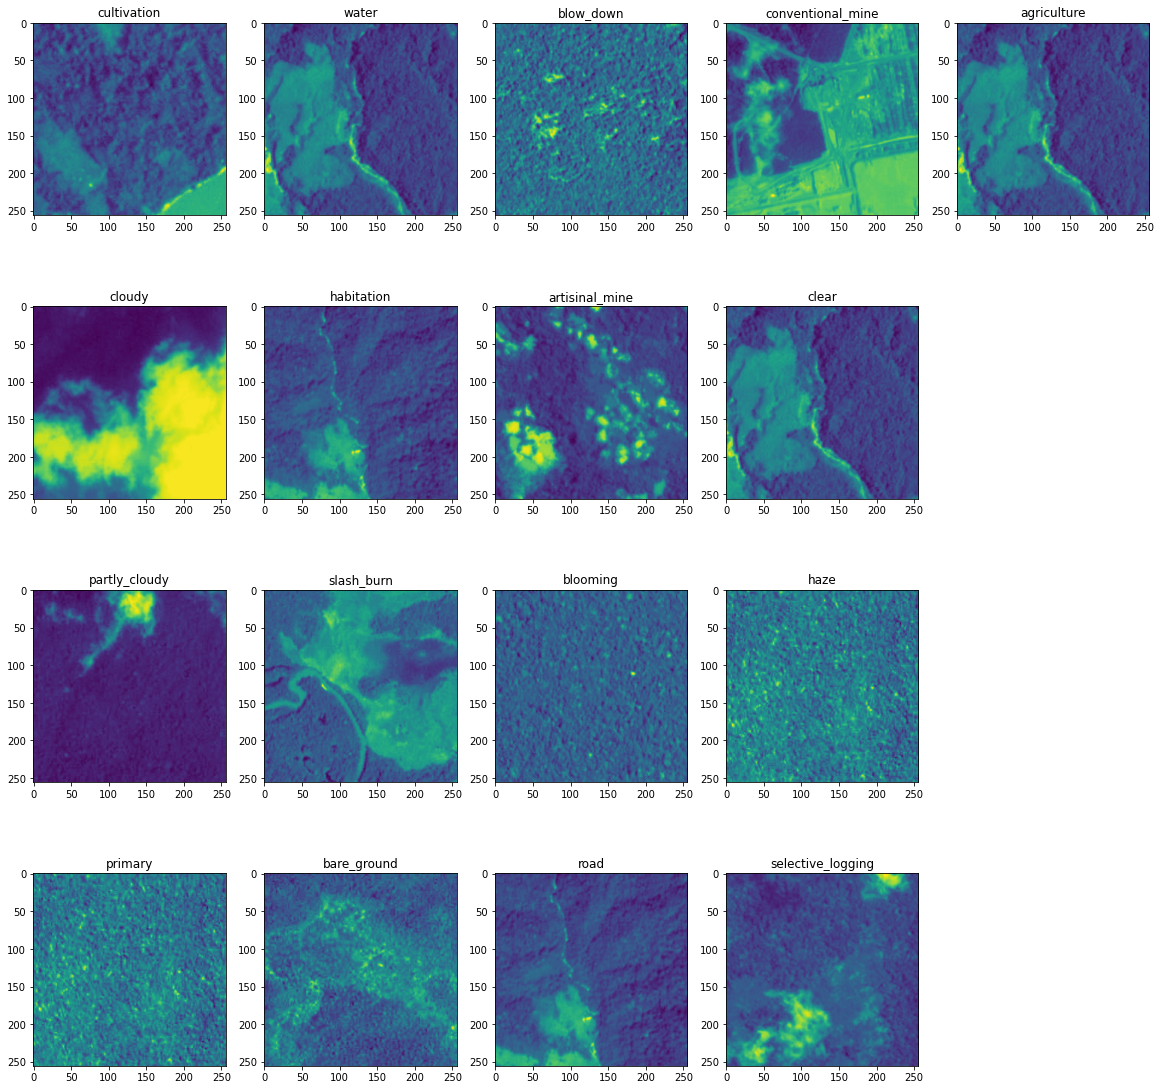

In [25]:
all_tags = list(set(tags))
Number_tags = len(all_tags)
fig, axes = plt.subplots(4, (Number_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(train_path, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

Some labels are hardly differentiable as seen from the plots above making it harder to differentiate between them.

# T-SNE and dimension shrinking for visualisation

T-SNE allows us to cluster our dataset by shrinking the image dimensions to only 2. It is useful for a quick visualisation of our dataset.

We need to convert each image to a normalized 1D vector that we can stack onto each other. This matrix will be the input of our TSNE.

In [27]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

We only sample 600 images as an estimation of our dataset diversity.

In [28]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(train_path, filename+".jpg") for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [29]:
tsne = TSNE(
    n_components=2,
    random_state=26,
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
X_embedded.shape

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.012s...
[t-SNE] Computed neighbors for 600 samples in 0.306s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 6.989538
[t-SNE] Computed conditional probabilities in 0.048s
[t-SNE] Iteration 50: error = 75.4497910, gradient norm = 0.4085679 (50 iterations in 0.346s)
[t-SNE] Iteration 100: error = 76.2028732, gradient norm = 0.3849438 (50 iterations in 0.255s)
[t-SNE] Iteration 150: error = 79.4830093, gradient norm = 0.3388272 (50 iterations in 0.364s)
[t-SNE] Iteration 200: error = 78.8307953, gradient norm = 0.3666523 (50 iterations in 0.357s)
[t-SNE] Iteration 250: error = 81.2953949, gradient norm = 0.3552257 (50 iterations in 0.242s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.295395
[t-SNE] Iteration 300: error = 1.2072500, gradient norm = 0.0068208 (50 iterations in 0.249s)
[t-SNE] Iteration 350: error = 1.0806274, gradient norm = 0.0011789 (

(600, 2)

In [30]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

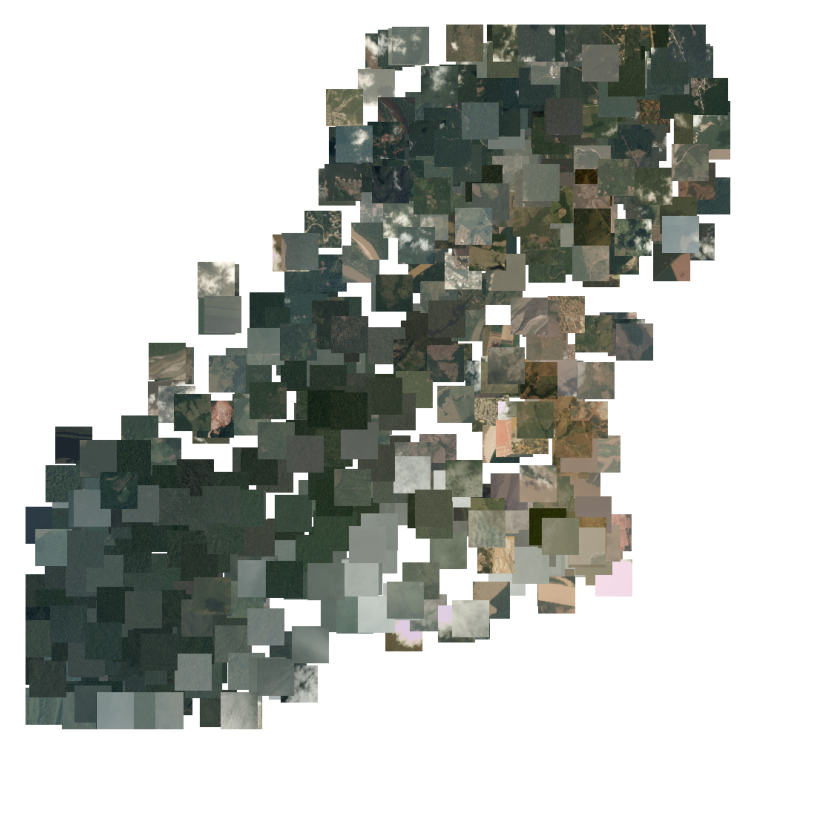

In [31]:
img_size = 1000
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * img_size).astype(int)
X_scaled = np.clip(X_scaled, offset_img, img_size-offset_img)

img_tsne = np.ones((img_size+2*offset_img, img_size+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(15, 15))
plt.imshow(img_tsne);
plt.axis("off");

# Model training

### Transformations

For optimal performances, resnet18 need input shape that are multiple of 32 and in our case we have input of size 256. From 256, the closest multiple of 32 is 224.

Therefore, we rescale our input data using this multiple, and we also normalize our dataset based on resnet pretrained mean and standard deviation intensity values. `ToTensor()` is useful to normalize our image values from 0-255 range to 0-1 range.

In [32]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val

In [33]:
class AmazonForestDatasetError(Exception):
    pass


class AmazonForestDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonForestDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonForestDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonForestDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

In [53]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonForestDataset(df_train, ohe_tags_train, transform_train, path=train_path)
    ds_val = AmazonForestDataset(df_val, ohe_tags_val, transform_val, path=train_path)

    dl_train = DataLoader(
      ds_train,
      batch_size=128,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=128,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

In [54]:
df_train, df_val = train_test_split(df_class, test_size=.3)

ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

imgs, labels = next(iter(dl_train))
print(imgs.shape, labels.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128, 17])


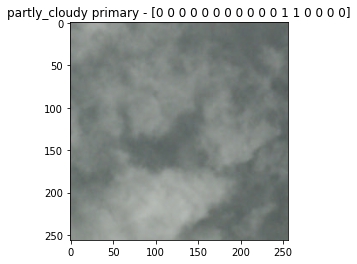

In [55]:
ds_train.load_img(57)

# Model definition

In [61]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.25),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

# Training

In [62]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

In [63]:
def train_model(dl_train, dl_val, idx_fold):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer,step_size=10 , gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 10
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

In [64]:
for rare_class in Rarer_tags:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1669% (614)
val bare_ground: 2.0422% (248)

train selective_logging: 0.8223% (233)
val selective_logging: 0.8811% (107)

train artisinal_mine: 0.8647% (245)
val artisinal_mine: 0.7740% (94)

train blooming: 0.8188% (232)
val blooming: 0.8235% (100)

train slash_burn: 0.5470% (155)
val slash_burn: 0.4447% (54)

train blow_down: 0.2612% (74)
val blow_down: 0.1976% (24)

train conventional_mine: 0.2506% (71)
val conventional_mine: 0.2388% (29)



In [65]:
train_model(dl_train, dl_val, 0)

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 0/10 -- train loss: 0.14037158595280605, val loss: 0.11261656849007858 -- train fbeta_score: 0.8721162545691834, val fbeta_score: 0.9030846663184504


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 1/10 -- train loss: 0.10999396614528992, val loss: 0.10474726110696793 -- train fbeta_score: 0.9038006338769051, val fbeta_score: 0.909120680361435


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 2/10 -- train loss: 0.1032697529204794, val loss: 0.09709241060834183 -- train fbeta_score: 0.9103029708566783, val fbeta_score: 0.9169356311461029


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 3/10 -- train loss: 0.10071846087639397, val loss: 0.09619701559606351 -- train fbeta_score: 0.9132485431810442, val fbeta_score: 0.9172925939314935


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 4/10 -- train loss: 0.09779612112555418, val loss: 0.09753757974034861 -- train fbeta_score: 0.9158051424822972, val fbeta_score: 0.9165264861334341


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 5/10 -- train loss: 0.09559241782974552, val loss: 0.09475286257894415 -- train fbeta_score: 0.917906159989559, val fbeta_score: 0.9201826299869924


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 6/10 -- train loss: 0.09459822467184281, val loss: 0.09265349879860878 -- train fbeta_score: 0.9186617478210714, val fbeta_score: 0.9190654368885535


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 7/10 -- train loss: 0.09285279272778614, val loss: 0.09266829529875203 -- train fbeta_score: 0.9202283121601672, val fbeta_score: 0.9206356760957903


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 8/10 -- train loss: 0.0924981277066845, val loss: 0.09111840466135426 -- train fbeta_score: 0.920503065406215, val fbeta_score: 0.921229056209648


  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

epoch: 9/10 -- train loss: 0.09095672863694998, val loss: 0.09379930072709133 -- train fbeta_score: 0.9222819638292085, val fbeta_score: 0.9206289559904213


In [67]:
model = torch.load("resnet18_fold0.pth")
train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [68]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="training loss",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="validation loss",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="training score",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="validation score",
    ),
    row=1, col=2
)
fig.show()

# Understanding results

### Extreme/Marginal probability

Displaying the average of our Y_hat prediction probability, when the truth is Y = 1 or Y = 0.

In [69]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

In [70]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [71]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.18, 0.13, 0.25, 0.16, 0.07, 0.1, 0.1, 0.11, 0.2, 0.12, 0.21, 0.08, 0.12, 0.22, 0.2, 0.17, 0.24] -- best score: 0.924471248418714


In [76]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

Half of the rare classes are below the 50% score, thus, there is room for improvement.

# Confusion matrixes

In [78]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=True, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

# Inference

In [79]:
!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc -l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l)

40669 + 20522


In [83]:
def get_test_data(idx_tta):
    test_path_table = "../input/planets-dataset/planet/planet"
    test_path_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    test_path_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    file_count = len(os.listdir(test_path_file_1)) + len(os.listdir(test_path_file_2))
    df_test = pd.read_csv(os.path.join(test_path_table, "sample_submission.csv"))
    
    assert df_test.shape[0] == file_count
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonForestDataset(
        df_test, ohe_tags_test, transform_val, path=[test_path_file_1, test_path_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test,
        shuffle=False,
        batch_size=128,
        collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [84]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [85]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

In [88]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)